# Supplementary material

Authors:  K. Kokabisaghi and E.J. Pauwels 

Affiliation:  Centrum Wiskunde & Informatica (CWI), Amsterdam, Netherlands.

Link to paper on Arxiv

Date:   March 2020

Version:  1.0

# Iterated MZ game simulation
v 2 June 2020, 17h

This Python notebook simulates the iterated MZ game. It addresses the following topics (corresponding roughly to cells): 

The corresponding paper 
K.Kokabisaghi, A.B. Dorsman, E.J. Pauwels:  etc. 
can be found [here](https://)

*  **[Game Environment](#scrollTo=zIC0V9kVt8kN&line=5&uniqifier=1)** : defines essential parameters that are needed in the stage game, as well as auxiliary functions.    

* **[HFT Class](#scrollTo=LvmZG3qhXazP&line=10&uniqifier=1)** : defines the essential characteristics of an HFT agent 
* **[Payoff Table](#scrollTo=jk-RuDHHiHHd&line=2&uniqifier=1)**:  represents dictionaries of payoffs in a set of conditions. 

*  **[Stage game](#2#scrollTo=iOs4cpxoTJ2N&line=7&uniqifier=1)**:  describes different stages of the game to compute corresponding payoff and utility

* **[Game setup](#scrollTo=50uiY8BH16M_&line=10&uniqifier=1)**:  defines basic parameters, compute Game Environment propertise to determines the profitable regiem for sniping probabilistically. 
* **[Instantiate list of agents](#scrollTo=g-cyEdvM1O5o&line=17&uniqifier=1)** :shows each agents' features and properties.
* **[Repeated game](#scrollTo=YAQ92qXZqPQ0&line=11&uniqifier=1)** : Play the stage game.
* **[Trigger Strategy based on Detection of Non-compliance](#scrollTo=C6ZVWLiAh9e_&line=4&uniqifier=1)** : represents the ways to detect non-compliance agents 

   by monitoring the [Frequency of winning the race](#scrollTo=Tu0hS3LL1kpX&line=2&uniqifier=1) and [Average/ aggregated utility](#scrollTo=yzuwxiOVAaSl&line=3&uniqifier=1) and [Sequential  utility testing](#scrollTo=tG2lZZ1Lhlqf&line=1&uniqifier=1) 

* **[How to quantify the non-compliance effect on race winning frequency](#scrollTo=SAcl0bvqa-lo&line=6&uniqifier=1)** : Quantifying the effect of deceptive agents on frequency of winning the race by comparing the expected number of times for winning the race and both actual and fair situation, agents can keep track of the number of times they win the race.

* **[Wald's sequential probability ratio test](#scrollTo=yn55wPl7Eq2m&line=17&uniqifier=1)** : Introduce Wald's sequential probability ratio test and check the validation of SPRT on simulation result.

In [ ]:
# Required Libraries 
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import pandas as pd
import collections  # for tabulate
import pprint
import operator



In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



# 1. Game environment (properties): 

In this section, we compute the following properties : 

1.  Define mz_params: A dictionary of parameters for MZ game ($H,\alpha,\mu, \delta, \sigma$)
2.   Risk Aversion factor =  $ \gamma \geq 1 $

3.   Equilibrium spread = optimum spread advertised by hft at start of game (t = -1)
4.   Equilibrium Utility = optimum expected utility based on advertised spread
5.   Optimum sniping probability = probability with which the hft will attempt to snipe when the opportunity arises



In [ ]:

#  Define the basic parameters that govern the game
#-==================================================

Ht = 4     # number of trustworthy agents
Hd = 1   # number of deceptive agents
H = Ht+Hd     #  number of HFTs 
alpha = .45     #  arrival rate for news 
mu = 0.45       #  arrival rate for liquidity trader
delta = 0.5    # latency of stock exchange 

# THe risk aversion factor is basically a attribute of an agent, but in this 
#  implementation we use identical values for all agents, so we can add this as 
#  an environemnt parameter
gamma =  3 #  identical risk aversion for all agents 

#  sigma = jumpsize of intrinsic value of an asset. 
#  In the paper we show that this is essentially a scaling factor which can be fixed to 1: 
sigma = 1      # DO NOT CHANGE THIS!

# Collect all the BASIC game parameters in dictionary
mz_params_basic = {'Ht':Ht, 'Hd':Hd,  'alpha':alpha, 'mu':mu, 'delta':delta, 'gamma': gamma, 'sigma':sigma }

#===========================
#  DEFINE AUXILIARY FUNCITON 
# ===========================


#----------------------------------------
def complete_mz_params(mz_params_basic):
#----------------------------------------  

  # Use the basic MZ parameters to compute the derived MZ parameters for later use
  mz_params = mz_params_basic    # copy the basic ones 
  
  # Unpack the basic MZ parameter
  Ht     = mz_params["Ht"]
  Hd     = mz_params["Hd"]
  H = Ht + Hd
  
  alpha  = mz_params["alpha"]
  mu     = mz_params["mu"]
  delta  = mz_params["delta"]  
  sigma  = mz_params["sigma"]   
  gamma  = mz_params["gamma"]   

  # Compute the related parameters and store them in the dictionary
  beta = alpha / (alpha+mu);                     mz_params['beta'] = beta
  mubar = mu * delta / 2;                        mz_params['mubar']=mubar
  alphabar = alpha * delta / 2 ;                 mz_params['alphabar']=alphabar
  m = 1 - mubar;                                 mz_params['m']=m
  h = (H-1)/H;                                   mz_params['h']=h
  thetabar = 2*alphabar*mubar/(alphabar+mubar);  mz_params['thetabar']= thetabar

  return mz_params

#-----------------------------------------
def K_cubic(gamma, mz_params):
#-----------------------------------------
  # unpack the parameters that we need to compute the polynomial

  alphabar = mz_params['alphabar']
  mubar    = mz_params['mubar']
  thetabar = mz_params['thetabar']
  beta  = mz_params["beta"]   
  Hd     = mz_params["Hd"]
  Ht     = mz_params["Ht"]
  H = Ht + Hd 

  # Compute the coefficients (see KPD_supplementary_material_1.ipynb for more details)
  K3  =  -alphabar*beta*(2*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 4*H**2*beta**2*mubar**2 - 4*H**2*beta**2*mubar + H**2*beta**2 - 4*H**2*beta*mubar*thetabar + 2*H**2*beta*thetabar + H**2*thetabar**2 - 6*H*alphabar*beta**2*mubar + 3*H*alphabar*beta**2 - 8*H*beta**2*mubar**2 + 8*H*beta**2*mubar - 2*H*beta**2 + 4*H*beta*mubar*thetabar - 2*H*beta*thetabar + 4*alphabar*beta**2*mubar - 2*alphabar*beta**2 + 4*beta**2*mubar**2 - 4*beta**2*mubar + beta**2)
  K2  =  alphabar*beta*(4*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 10*H**2*beta**2*mubar**2 - 9*H**2*beta**2*mubar + 2*H**2*beta**2 + 4*H**2*beta*mubar**2 - 9*H**2*beta*mubar*thetabar + 2*H**2*beta*mubar + 3*H**2*beta*thetabar - 2*H**2*beta - H**2*mubar*thetabar + 3*H**2*thetabar**2 - H**2*thetabar - 12*H*alphabar*beta**2*mubar + 3*H*alphabar*beta**2 - 18*H*beta**2*mubar**2 + 15*H*beta**2*mubar - 3*H*beta**2 - 4*H*beta*mubar**2 + 8*H*beta*mubar*thetabar - 2*H*beta*mubar - 2*H*beta*thetabar + 2*H*beta + 8*alphabar*beta**2*mubar - 2*alphabar*beta**2 + 8*beta**2*mubar**2 - 6*beta**2*mubar + beta**2)
  K1  =  -beta*(2*H**2*alphabar**2*beta**2*mubar + H**2*alphabar**2*beta**2 + 6*H**2*alphabar*beta**2*mubar**2 - 2*H**2*alphabar*beta**2*mubar - H**2*alphabar*beta**2 + 4*H**2*alphabar*beta*mubar**2 - 6*H**2*alphabar*beta*mubar*thetabar + 4*H**2*alphabar*beta*mubar - 2*H**2*alphabar*mubar*thetabar + 3*H**2*alphabar*thetabar**2 - 2*H**2*alphabar*thetabar + H**2*beta*mubar**2*thetabar - 2*H**2*beta*mubar*thetabar + H**2*beta*thetabar + H**2*mubar**2*thetabar - H**2*thetabar - 6*H*alphabar**2*beta**2*mubar - 3*H*alphabar**2*beta**2 - 10*H*alphabar*beta**2*mubar**2 + 2*H*alphabar*beta**2*mubar + 2*H*alphabar*beta**2 - 4*H*alphabar*beta*mubar**2 + 4*H*alphabar*beta*mubar*thetabar - 4*H*alphabar*beta*mubar + 2*H*alphabar*beta*thetabar + 4*alphabar**2*beta**2*mubar + 2*alphabar**2*beta**2 + 4*alphabar*beta**2*mubar**2 - alphabar*beta**2)
  K0  =  beta*(H**2*alphabar**2*beta**2 + 3*H**2*alphabar*beta**2*mubar - 2*H**2*alphabar*beta**2 - H**2*alphabar*beta*mubar*thetabar + 2*H**2*alphabar*beta*mubar - H**2*alphabar*beta*thetabar + 2*H**2*alphabar*beta - H**2*alphabar*mubar*thetabar + H**2*alphabar*thetabar**2 - H**2*alphabar*thetabar - H**2*beta**2*mubar**3 + 3*H**2*beta**2*mubar**2 - 3*H**2*beta**2*mubar + H**2*beta**2 - 2*H**2*beta*mubar**3 + H**2*beta*mubar**2*thetabar + 2*H**2*beta*mubar**2 - 2*H**2*beta*mubar*thetabar + 2*H**2*beta*mubar + H**2*beta*thetabar - 2*H**2*beta - H**2*mubar**3 + H**2*mubar**2*thetabar - H**2*mubar**2 + H**2*mubar - H**2*thetabar + H**2 - 3*H*alphabar**2*beta**2 - 5*H*alphabar*beta**2*mubar + 3*H*alphabar*beta**2 - 2*H*alphabar*beta*mubar + 2*H*alphabar*beta*thetabar - 2*H*alphabar*beta + 2*alphabar**2*beta**2 + 2*alphabar*beta**2*mubar - alphabar*beta**2)

  # compute cubic polynomial 
  K_gamma  = K3*gamma**3 + K2*gamma**2 + K1*gamma + K0;
  return K_gamma

# ----------------------------------
def compute_gamma_bar_K(mz_params):
# ----------------------------------
  # Computes threshold gamma_bar_K below which probabilistic sniping is not profitable. 

  #  Step 1: Define coefficients K3,K2,K1,K0 for the cubic polynomial 
  #     K_cubic(gamma) = K3*gamma**3 + K2*gamma**2 + K1*gamma + K0

  #  Step 2: find zero-crossing (basic straightforward way: )

  #  First check that K(1) = K3 + K2 + K1 + K0 > 0 (if not, create error message)
  #  start with gamma_bar_K = 1 and increment slightly until K(gamma_bar_K) <0

  gamma_bar_K = 1
  #print(K_cubic(gamma_bar_K,mz_params))

  #  if K_cubic(1) < 0, throw exception/error message -- STILL TO DO!! 
  if K_cubic(gamma_bar_K,mz_params) <= 0: 
    print('ERROR -- PROVIDE COMMENT -- EXIT')  #  EJP

  while K_cubic(gamma_bar_K,mz_params) > 0:
    gamma_bar_K = gamma_bar_K + 0.005

  return gamma_bar_K 



# ----------------------------------
def compute_gamma_bar_L(mz_params):
# ----------------------------------
  alphabar = mz_params['alphabar']
  mubar = mz_params['mubar']
  thetabar = mz_params['thetabar']
  beta = mz_params['beta']
  Z = (1-beta)+ (1+beta)*mubar

  gamma_bar_L = 1 + np.sqrt((1-mubar)*Z/(alphabar*thetabar))

  return gamma_bar_L


#-----------------------------
def compute_equilibrium_spread_utility(p, mz_params): 
#-----------------------------  
  # Compute for given sniping prob p , risk gamma and the other parameters, 
  #  by comping A(gamma,p), B , C D and then computing the intersction 
  # of the line AB and CD (linear utility functions)

  # Unpack the MZ parameter
    Ht     = mz_params["Ht"]
    Hd     = mz_params["Hd"]
    H = Ht + Hd
    alpha  = mz_params["alpha"]
    mu     = mz_params["mu"]
    delta  = mz_params["delta"]
    sigma  = mz_params["sigma"]
    beta   = mz_params["beta"]
    thetabar = mz_params["thetabar"]
    mubar  = mz_params["mubar"]
    alphabar = mz_params["alphabar"]
    m      = 1-mubar
    gamma  = mz_params["gamma"]

    h = ( p*H - 1 + (1-p)**H)/ (p*H)
    g = h/((H-1)*p)
    
    # Compute the point of indifference (intersection of both utilities)
    q = gamma - 1
    A =  m * beta *g*p
    B = -q * alphabar * beta *g*p
    C = -( q * thetabar + h * beta*(m* gamma - mubar*q))
    D =  (1+ mubar) - beta*(1-mubar) - alphabar * beta* h * q
    # Finally, update the corresponding attributes  
    s_star = (A-C) / ((A-C) + (D-B))
    u_star = (A*D-B*C) / ((A-C) + (D-B))
    
    # Compute the point of indifference and 
    # utility when there is deceptive agent 
    #----
    Nt = np.random.binomial(Ht-1, p)
    h_tm = np.mean((Hd+Nt) / (1+Hd+Nt))
    Nt_1 = np.random.binomial(Ht-2, p)
    Nt_2 = np.random.binomial(Ht-1, p)
    g_tb = np.mean(1/(2+Hd+Nt_1))*((Ht-1)/(H-1)) + np.mean(1/(1+Hd+Nt_2))*(Hd/(H-1))
    #---
    A_tb =  m * beta *g_tb*p
    B_tb = -q * alphabar * beta *g_tb*p
    C_tm = -( q * thetabar + h_tm * beta*(m* gamma - mubar*q))
    D_tm =  (1+ mubar) - beta*(1-mubar) - alphabar * beta* h_tm * q
    # Update the corresponding attributes   
    ut_as_bandit = A_tb*(1-s_star) + B_tb*s_star
    ut_as_mm = C_tm*(1-s_star) + D_tm*s_star    
    u_as_t = ((H-1)/H)*ut_as_bandit + (1/H)*ut_as_mm;  

    #  Collect output in dictionary
    equilibrium_info = {'s_star' : s_star, 'u_star' : u_star, 'A': A, 'B' : B, 'C' : C, 'D' : D, 'util_as_t': u_as_t}

    return equilibrium_info

#-----------------------------
def compute_p_star(mz_params): 
#-----------------------------
  ''' 
  computes optimal sniping probability p_star and corresponding utility u_star

  Usage: 
  p_star, util_p_star = compute_p_star(mz_params)

  '''
 
  P = np.linspace(0.01,1, 100)
  u_star_total_p =[]
  for p in P:
    equilibrium_info = compute_equilibrium_spread_utility(p, mz_params)
    u_star_p = equilibrium_info['u_star']
    u_star_total_p.append(u_star_p)
    index, util_p_star = max(enumerate(u_star_total_p), key=operator.itemgetter(1))
    p_star = P[index]
    
  return p_star, util_p_star


#--------------------------------------  
def compute_utility_from_eventcode(outcome_stagegame, mz_params,s_now):
#-------------------------------------
    
    # Decode the event_code and assign values using spread s
    event_code = outcome_stagegame['event_code']
    rw = outcome_stagegame['rw']
    mm = outcome_stagegame['mm']
    s = s_now
  
    
    #  Unpack the required mz_parameters
    alpha = mz_params['alpha']  
    mu    = mz_params['mu']  
    delta = mz_params['delta']  
    sigma = mz_params['sigma']  

    # Utility for given eventcode, mm, rw
    #---------------------
    # Initialise
    mm_payoff_now = 0
    rw_payoff_now = 0


    if rw < 0 :  #  there was no race
      mm_payoff_now = eval(mm_payoff_no_race[event_code])
    elif rw >=0 and rw == mm :   #  there was a race and it was won by market maker (mm and rw are assigned same utility)
      mm_payoff_now = eval(mm_payoff_race_winner[event_code])
      rw_payoff_now = mm_payoff_now
    elif rw >=0 and rw != mm : # there was a race and it was won by bandit 
      mm_payoff_now = eval(mm_payoff_race_loser[event_code])
      rw_payoff_now = eval(bandit_payoff_race_winner[event_code])
  
    # negative utilities are inflated by risk factor gamma
    mm_utility_now = mm_payoff_now
    rw_utility_now = rw_payoff_now 
    if mm_utility_now < 0:      
      mm_utility_now = mm_utility_now * gamma
    if rw_utility_now < 0:      
      rw_utility_now = rw_utility_now * gamma

    #  Save results in array for export 
    utility_eventcode = np.zeros(H)  
    utility_eventcode[mm] = mm_utility_now
    if  rw >= 0  and rw != mm:         #  CORRECTION  13 JUNE 2020, ADDED CONDITION ON rw >= 0
      utility_eventcode[rw] = rw_utility_now

    return utility_eventcode




#2. Agents (HFT) class

This class creates following features for HFT agents: 

Agents ID and nature, Spread, Risk aversion level, Sniping probability.


In [ ]:
class HFT:

  def __init__(self, mz_params):
   
    # At initialisation of the object do all of the following: 

    #  Initialise the attributes that characterise the individual trader
    self.id = None    #  HFT ID, to be assigned at creation 
    self.mm = 0       #  will this agent act as market maker (1 = yes, 0 = no)
    self.spread = 0
    self.gamma = 1      # individual risk aversion 
    # probability with which agent will enter race if there is a race (for bandits this is the sniping prob)
    self.p = 1  # actual racing/sniping prob, sure racing/sniping (i.e. p = 1) is default
    
    self.nature = 'T'   # agent's nature is either trustworthy (T, default) or deceptive (D)
  
# -------------------- END HFT CLASS DEFINITION  -------------------

 

In [ ]:
#---------------------------------------------------
#  Create a list of HFTs with given configuration
#----------------------------------------------------

def create_hft_list(mz_params,spread_now,p_now): 

  ''' Create a list of HFTs of which Ht are trustworthy and Hd are deceptive 
   with common spread spread_now and snipint prob p_now (at least for the trustworthy agents) 
   '''
  hft_list = []    # initialise 

  # Unpack the MZ parameter
  Ht     = mz_params["Ht"]
  Hd     = mz_params["Hd"]
  gamma  = mz_params["gamma"]
  H = Ht + Hd
    
  for i in range(H):   
    hft = HFT(mz_params)   # instantiate a new HFT agent
    hft.id = i     #  assign ID to this agent
    hft.gamma = gamma   # assign the current risk aversion factor to each agent
    hft.spread = spread_now    #  all agents (including deceptive ones) advertise common spread
    hft.p  = p_now
    hft.nature = 'T'     #  default value for hft's nature is Trustworthy

    # introduce changes for DECEPTIVE agents
    if i >= Ht:  # this agent is deceptive! 
      hft.nature = 'D'   # change nature to deceptive
      hft.p = 1          # deceptive agents snipe for sure
      
    # append this hft to the hft-list 
    hft_list.append(hft)    #  add this hft to the list

  return hft_list

 



# 3. Payoff Table: 

The table reprtesents **possible event codes** in the game and **corresponding payoffs** at the end of the stage game ($ t = \delta$).

The dictionaries show payoffs for both types of agents market maker (mm) and Bandit when there is/not a race and agents win or lose the race. 


In [ ]:

# Create dictionary of event codes and corresponding payoffs

print('MM payoff when there is NO race')

mm_payoff_no_race = {'LA-LA':'s','LA-LB':' 2*s', 'LA-NG': 's-sigma','LA-NB': 's+sigma', 'LA-NO': 's', 'LB-LA': '2*s', 'LB-LB':' s',
                     'LB-NG': 's+sigma','LB-NB': 's-sigma' , 'LB-NO': 's'}
pprint.pprint(mm_payoff_no_race)
print(' ')

print('MM payoff if there is a race and he loses race ')
mm_payoff_race_loser = { 'NG-LA':'s-sigma', 'NG-LB':'2*s', 'NG-NG': 's-2*sigma', 'NG-NB':'s', 'NG-NO': 's-sigma',
                     'NB-LA': '2*s', 'NB-LB':'s-sigma', 'NB-NG': 's', 'NB-NB': 's-2*sigma','NB-NO':'s-sigma' }
                      
pprint.pprint(mm_payoff_race_loser)
print(' ')
#===============================================================
print('MM payoff if there is a race and he wins')
mm_payoff_race_winner = {                     
             'NG-LA':'s-sigma', 'NG-LB':'sigma+s', 'NG-NG': '0', 'NG-NB':'0','NG-NO': '0',
             'NB-LA': 's+sigma', 'NB-LB': 's-sigma', 'NB-NG': '0','NB-NB': '0','NB-NO':'0'}

pprint.pprint(mm_payoff_race_winner)
#===============================================================

#  Bandit pay-off is non-zero only if he wins the race. Otherwise his payoff is zero. 
#  But even if he does, he might get scooped by a LT and end up with empty handed!  
bandit_payoff_race_winner = {'NG-LA':'0', 'NG-LB':'sigma-s', 'NG-NG': '2*sigma- s', 'NG-NB':'-s', 'NG-NO': 'sigma-s','NB-LA': 'sigma-s', 
                 'NB-LB':'0', 'NB-NG': '-s', 'NB-NB': '2*sigma-s','NB-NO':'sigma-s' }

print(' ')
print('Bandit pay-off if there is a race and wins it')
pprint.pprint(bandit_payoff_race_winner)                        

#  Collect the tables (dictionaries) in a dictionary

payoff_tables = {'no_race' : mm_payoff_no_race,  'mm_race_winner' : mm_payoff_race_winner, 'mm_race_loser' : mm_payoff_race_loser, 'bandit_race_winner' : bandit_payoff_race_winner}


MM payoff when there is NO race
{'LA-LA': 's',
 'LA-LB': ' 2*s',
 'LA-NB': 's+sigma',
 'LA-NG': 's-sigma',
 'LA-NO': 's',
 'LB-LA': '2*s',
 'LB-LB': ' s',
 'LB-NB': 's-sigma',
 'LB-NG': 's+sigma',
 'LB-NO': 's'}
 
MM payoff if there is a race and he loses race 
{'NB-LA': '2*s',
 'NB-LB': 's-sigma',
 'NB-NB': 's-2*sigma',
 'NB-NG': 's',
 'NB-NO': 's-sigma',
 'NG-LA': 's-sigma',
 'NG-LB': '2*s',
 'NG-NB': 's',
 'NG-NG': 's-2*sigma',
 'NG-NO': 's-sigma'}
 
MM payoff if there is a race and he wins
{'NB-LA': 's+sigma',
 'NB-LB': 's-sigma',
 'NB-NB': '0',
 'NB-NG': '0',
 'NB-NO': '0',
 'NG-LA': 's-sigma',
 'NG-LB': 'sigma+s',
 'NG-NB': '0',
 'NG-NG': '0',
 'NG-NO': '0'}
 
Bandit pay-off if there is a race and wins it
{'NB-LA': 'sigma-s',
 'NB-LB': '0',
 'NB-NB': '2*sigma-s',
 'NB-NG': '-s',
 'NB-NO': 'sigma-s',
 'NG-LA': '0',
 'NG-LB': 'sigma-s',
 'NG-NB': '-s',
 'NG-NG': '2*sigma- s',
 'NG-NO': 'sigma-s'}


#4. Stage game : 

This function creates a single stage game for the game by .. game setup and propertise 

* Inputs: Agents list, Optimum spread and initial parameters (mz_aparams)
* Outputs: Event codes, race winner, market maker.

In [ ]:

def mz_stagegame_mixed_agents(mz_params, hft_list):

    """ 
    This function rolls out a single stage-game for an MZ game 
    with game parameters, mz_params and a group of hfts (specified in hft_list)

    OUTPUT:  'outcome_stagegame' which is a dictionary with the following entries:  

    """
    
    # create empty dictionary for output
    outcome_stagegame  = dict()   # empty dictionary

    #  Unpack the required MZ game parameters
    beta = mz_params['beta'];  mu = mz_params['mu'];  delta = mz_params['delta']
    Ht = mz_params['Ht']; Hd = mz_params['Hd']
    H = Ht+Hd
    
    event_code = ''     # encodes the sequence of events during the game
    rw = -1     #  Keeps track of ID of race winner (0 thru H-1). Default, as there hasn't been a race yet

    #--------------------------------------------------
    #  Pick the market maker at random among the hfts with minimal optimal spread
    #-----------------------------------------------------
    #  and set the mm-indicator of the corresponding hft to 1.
    #  Assign values to all the relevant MM parameters
    #  NOTE: in this implementation, all HFTs have identical spread, so determining 
    #     the IDs of the ones with minimal spread is superfluous, but we keep it in
    #     in case we want to extend the algos to more general setting. 

    #  First we extract the list of spreads for convenience: 
    spread_list = []
    for ii in range(H): 
      spread_list.append(hft_list[ii].spread)

    hft_ids_with_min_spread = [i for i, x in enumerate(spread_list) if np.abs(x - min(spread_list)) < 1e-6]

    mm = rand.choice(hft_ids_with_min_spread)   # ID of marketmaker 
 
    #  Store in output
    outcome_stagegame["mm"] = mm;

    # Update the relevant parameters of the MM-agent
    hft_list[mm].mm = 1    #  This hft in the list is market maker
    # hft_list[mm].p = 1   #  the market maker will always race!
  
    #-----------------------------------------
    #  Make a list of the hfts that will race
    #-----------------------------------------
    #  This list is non-empty as MM will always race (if triggered by NEWS)
    
    hfts_in_race_ids = [mm];     # ids of hft that participate in race
    for i in range(H):
      if i!= mm:  # skip market maker 
        # for each hft agent, OTHER THAN THE MM, generate a binomial indicator (1/0) using his specific racing prob
        #print('Agent ', i , ' has racing prob = ' , hft_list[i].p)
        in_race_indicator = np.random.binomial(1, hft_list[i].p, 1)

        if in_race_indicator[0] == 1:
          hfts_in_race_ids.append(i)    # add id of this HFT to list of hfts in race



    outcome_stagegame['hfts_in_race_ids'] = hfts_in_race_ids  # store for checking    
   
    #---------------------------------
    #  First (trigger) event: either news (which starts race), or LT arrival (no race)
    #--------------------------------

    if rand.random() < beta:   # first trigger event is news arrival (prob = beta)
        # determine whether the news was good or bad  (equal probs)
        if rand.random()< .5:
            event_code += 'NG'   # good news
        else:
            event_code += 'NB'   #  bad news

        # Furthermore, news will trigger a race and we therefore have to determine the racewinner
        #------------------------------------------------------------------------
        #  The racewinner is picked at random (uniformly) among the hft in the race (hfts_in_race_ids)

        rw = rand.choice(hfts_in_race_ids)
        

    else:     #trigger event is LT arrival (probability = 1-beta)
        # deteremine whether LT goes for ask or bid
        if rand.random() < .5 :
            event_code += 'LA'   #  LT on Ask
        else:
            event_code += 'LB'   #  LT on Bid
    #---------------------------------
    #  Second event (either News, LT or None)
    #---------------------------------
    random_number_2 = rand.random()

    if random_number_2<= mu*delta: #Second trigger event is LT arrival (prob = mu*delta)
        if rand.random()< .5:
            event_code += '-LA'    #  LT on Ask
        else: 
            event_code += '-LB'    #  LT on Bid

    elif random_number_2 > mu*delta and random_number_2 <= (alpha+mu)*delta: #Second trigger event is news arrival
        if rand.random()< .5:
            event_code +=  '-NG'
        else:
            event_code +=  '-NB'

    else: #no second event
        event_code +=  '-NO'

   
    #  Create a dictionary that collects output
    
    outcome_stagegame['event_code'] = event_code
    outcome_stagegame['rw'] = rw


    return outcome_stagegame     #  output the event description

Equilibrium info
  A =  0.0589
  B =  -0.0149
  C =  -0.8715
  D =  0.6091
--------- s =  0.0  ---------------
 util_mean_for_this_spread_mm =  -1.0760842627013631
 util_mean_for_this_spread_bandit =  0.04985906670842468
--------- s =  0.2  ---------------
 util_mean_for_this_spread_mm =  -0.721862745098066
 util_mean_for_this_spread_bandit =  0.03687185929648238
--------- s =  0.4  ---------------
 util_mean_for_this_spread_mm =  -0.3595196397297875
 util_mean_for_this_spread_bandit =  0.023270636755608556
--------- s =  0.6000000000000001  ---------------
 util_mean_for_this_spread_mm =  -0.05296523517382491
 util_mean_for_this_spread_bandit =  0.01376181004475397
--------- s =  0.8  ---------------
 util_mean_for_this_spread_mm =  0.2604013208026303
 util_mean_for_this_spread_bandit =  -0.0008840191745004148
--------- s =  1.0  ---------------
 util_mean_for_this_spread_mm =  0.5640019617459539
 util_mean_for_this_spread_bandit =  -0.011493530963446803
Util_mean_for_this_spread_mm =

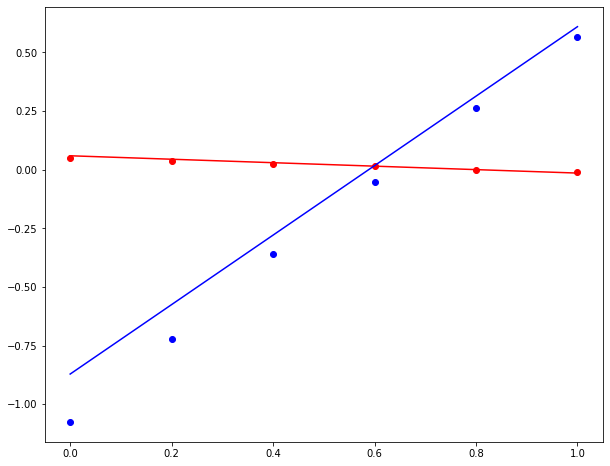

In [ ]:
# Checking the expression for the utilities derived in the paper 
#---------------------------------------------------------------

# We want to check whether the game simulations produce average utilities that 
# lie on the theoretically computed AB and CD lines. 

# We first check for sure sniping 

p_sure = 1     # sure sniping 

#  SWITCH BETWEEN SURE AND PROBALISTIC SNIPING 
#  Depending on the whether you want to run the sure of probabilistic sniping scenario, 
#  comment out one of the options. 
# p_now = p_sure     # SURE SNIPING


# Expand the parameters by computing all the DERIVED parematers and collect in new dictionary
mz_params = complete_mz_params(mz_params_basic)


p_star, util_p_star = compute_p_star(mz_params)

p_now = p_star       # PROBABILISTIC SNIPING

spread_now = 0.5  # this is an arbitrary value that will be changed later on 

# Compute for this game information on the equilibrium 
equi_info = compute_equilibrium_spread_utility(p_now , mz_params)
A = equi_info['A']
B = equi_info['B']
C = equi_info['C']
D = equi_info['D']

print('Equilibrium info') 
print('  A = ', round(A,4))
print('  B = ', round(B,4))
print('  C = ', round(C,4) )
print('  D = ', round(D,4) )



#  Create a fresh list of agents 
hft_list_check  = create_hft_list(mz_params,spread_now,p_now)


##  TO DO :  Compute the endpoints for each situation, ie. A, B, C, D

nr_game_iters = 20000


#  We will simulate the game for a number of discrete spreads collected in S
nr_interpolation_pts = 6
S = np.linspace ( 0, 1, nr_interpolation_pts)   # interpolation points btw 0 and 1

# The simulated (and averaged) means (for each of the values in S) will for both 
# market maker and bandit will be collected in the following list 
Util_mean_for_this_spread_mm = []
Util_mean_for_this_spread_bandit = []


for s in S:   # loop over the different spreads

    print('--------- s = ', s, ' ---------------')

    Util_for_this_spread = np.zeros((nr_game_iters, H))   # collect for each agent the utility in every game 
    MM_check = np.zeros(nr_game_iters)        #  keep track who the market maker in each game is. 

    # Update the hft spread for the current value of the spread
    for ii in range(H):
      hft_list_check[ii].spread = s
    
    #  Run the game a large number of times 

    for game_iter in range (nr_game_iters ) :  # loop over stage games:

        outcome_stagegame = mz_stagegame_mixed_agents ( mz_params, hft_list_check )
        utility_eventcode  = compute_utility_from_eventcode(outcome_stagegame, mz_params,s)
        mm = outcome_stagegame['mm']    # determine who the market maker was 

        Util_for_this_spread[game_iter] = utility_eventcode

        MM_check[game_iter] = mm   #  keep track of the market maker

    # For the current value of spread s, show simulation uilities and MM

    #print('----------------------------')
    # print('Current value of s = ', s)    
    # print(Util_for_this_spread) 
    # print(MM_check)

    #  Compute for a specific agent (in this case agent 0) his mean utility in both roles 
    #  (i.e. as market maker and bandit )

    util_total_for_this_spread_mm  = 0        #  role = market maker 
    util_total_for_this_spread_bandit = 0     #  role = bandit 
    nr_as_mm = 0
    nr_as_bandit = 0

    for game_iter in range(nr_game_iters): 
      if MM_check[game_iter] ==  0:       # agent 0 was market maker
        util_total_for_this_spread_mm = util_total_for_this_spread_mm + Util_for_this_spread[game_iter,0]
        nr_as_mm += 1
      else:                               # agent 0 acted as bandit 
        util_total_for_this_spread_bandit = util_total_for_this_spread_bandit + Util_for_this_spread[game_iter,0]
        nr_as_bandit += 1
 
    util_mean_for_this_spread_mm      = util_total_for_this_spread_mm/nr_as_mm   #nr_game_iters
    util_mean_for_this_spread_bandit  = util_total_for_this_spread_bandit/nr_as_bandit  #nr_game_iters

    print(' util_mean_for_this_spread_mm = ' ,   util_mean_for_this_spread_mm)
    print(' util_mean_for_this_spread_bandit = ',  util_mean_for_this_spread_bandit )

    Util_mean_for_this_spread_mm.append(util_mean_for_this_spread_mm)
    Util_mean_for_this_spread_bandit.append(util_mean_for_this_spread_bandit)

    # print('MM= ', MM)


print('Util_mean_for_this_spread_mm = ', np.round(Util_mean_for_this_spread_mm,4))
print('Util_mean_for_this_spread_bandit = ', np.round( Util_mean_for_this_spread_bandit,4))

plt.plot(S, Util_mean_for_this_spread_bandit, 'ro')
plt.plot(S, Util_mean_for_this_spread_mm, 'bo')
plt.plot([0, 1],[A, B],'r-')   #  Theoretical result: linear expected utility for bandit  
plt.plot([0, 1],[C, D],'b-')   #  Theoretical result: linear expected utility for market maker  


# 5. Setting up the game: 
* Define basic parameters
* Compute risk aversion level
* Compute equilibrium spread and utility 

And finally, 


*   Determine which sniping regime is most profitable.



In [ ]:
#  MAIN PROGRAM

#  The basic parameters have been defined in first cells! 

print('Setting up game with the following parameters')
print('=============================================')
print(' ')
pprint.pprint(mz_params_basic)
print(' ')

# Expand the parameters by computing all the DERIVED parematers and collect in new dictionary
mz_params = complete_mz_params(mz_params_basic)


#-----------------------------------------------------------------------------
# Determine which sniping regime is most profitable for these game parameters
#-----------------------------------------------------------------------------

# Compute the gamma-thresholds

gamma_bar_K = compute_gamma_bar_K(mz_params)
gamma_bar_L = compute_gamma_bar_L(mz_params)

print('gamma_bar_K = ' , gamma_bar_K)
print('gamma_bar_L = ' , gamma_bar_L)
print(' ')

# Compute optimal spread and corresponding utility for sure sniping 
p=1
equilibrium_info  = compute_equilibrium_spread_utility(p, mz_params)
u_star_sure = equilibrium_info['u_star']
s_star_sure = equilibrium_info['s_star']

print('\nFor SURE SNIPING in this environment we get: ')
print('    equilibrium spread =  ',  s_star_sure )
print('    equilibrium utility   =  ',  u_star_sure )

print('\nDetermining appropriate game regime')
if gamma <= gamma_bar_K: 
  print('  Since risk aversion factor gamma < gamma_bar_K,  SURE SNIPING IS OPTIMAL')
  p_star = 1
  s_star = s_star_sure
  u_star = u_star_sure
elif gamma >= gamma_bar_L: 
  print('  Since risk aversion factor gamma > gamma_bar_L,  THIS GAME IS NOT PROFITABLE')
  # EJP: is er a way to stop the program now ???
else:   #  gamma_bar_K < gamma < gamma_bar_L 
  print('  Since gamma_bar_K < gamma < gamma_bar_L PROBABILSTIC SNIPING IS OPTIMAL')
  # Compute the corresponding prob, spread and utility  
  p_star, util_p_star = compute_p_star(mz_params)
  equi_info = compute_equilibrium_spread_utility(p_star,mz_params)   # NOTICE:  u_star should be equal to util_p_star
  s_star = equi_info['s_star']
  u_star = equi_info['u_star']
  print('\nFor probilistic sniping we have the following parameters: ')
  print('  optimal sniping probability (p*) = ', p_star)
  print('      corresponding spread s*(p*)     = ',  s_star)
  print('      corresponding utility u(s*(p*)) = ',  u_star)
 
  #  EJP  create warning or error (throw exception) if u_star NOT EQUAL to util_p_star
if util_p_star != u_star:
  print('ERROR -- utility should be checked')
    


Setting up game with the following parameters
 
{'Hd': 1,
 'Ht': 4,
 'alpha': 0.45,
 'alphabar': 0.1125,
 'beta': 0.5,
 'delta': 0.5,
 'gamma': 3,
 'h': 0.8,
 'm': 0.8875,
 'mu': 0.45,
 'mubar': 0.1125,
 'sigma': 1,
 'thetabar': 0.1125}
 
gamma_bar_K =  2.444999999999969
gamma_bar_L =  7.847996913579551
 

For SURE SNIPING in this environment we get: 
    equilibrium spread =   0.6818783068783069
    equilibrium utility   =   0.012891038359788363

Determining appropriate game regime
  Since gamma_bar_K < gamma < gamma_bar_L PROBABILSTIC SNIPING IS OPTIMAL

For probilistic sniping we have the following parameters: 
  optimal sniping probability (p*) =  0.39
      corresponding spread s*(p*)     =  0.598559976663086
      corresponding utility u(s*(p*)) =  0.014694766013230049



# 5.1.  Instantiate a list of H hfts :


In [ ]:

#  MAIN CONTINUED 

#------------------------------------------
#  Instantiate a list of H hfts with equilibrium parameters s_star and p_star
#------------------------------------------

hft_list = create_hft_list(mz_params,s_star,p_star)

# Print out for a visual check

for i in range(len(hft_list)): 
  print('\n HFT ', i , ':  nature = ', hft_list[i].nature , ',  spread = ',  round(hft_list[i].spread,3), ',    racing/sniping prob = ', round(hft_list[i].p,3))





 HFT  0 :  nature =  T ,  spread =  0.599 ,    racing/sniping prob =  0.39

 HFT  1 :  nature =  T ,  spread =  0.599 ,    racing/sniping prob =  0.39

 HFT  2 :  nature =  T ,  spread =  0.599 ,    racing/sniping prob =  0.39

 HFT  3 :  nature =  T ,  spread =  0.599 ,    racing/sniping prob =  0.39

 HFT  4 :  nature =  D ,  spread =  0.599 ,    racing/sniping prob =  1


# 6. Repeated game:

Repeat the stage game for two conditions:
* fair (when all agents are trustworthy)
* actual (when there is/are deceptive agents in the game) 
----
*   Input: stage game set up, Table of payoffs
*   Output: Utility for each agents, Race winner, Market maker 


In [ ]:
#  MAIN  CONTINUED
# #-----------------------------------------
# #  Now play the stage game a large number of times and compute the mean payoff 
# #-------------------------------------------------

nr_game_iterations = 10000

RW = []   # initialise list that will contain the ID of the racewinner in each stagegame (-1 if there was no race)
MM = []   # initialise list that will contain the ID of the market maker in each stagegame 

RW_fair =[] # initialise list that will contain the ID of the racewinner in each stagegame (scenario in which all agents (H = Ht+Hd) are trustworthy)
MM_fair =[] # initialise list that will contain the ID of the market maker in each stagegame (scenario in which all agents (H = Ht+Hd) are trustworthy)

# Create a matrix of size nr_game_iterations x H to collect all the utilities.  
# Each row represents the utilities for one stage game 

Util = np.zeros((nr_game_iterations,H))
Util_fair = np.zeros((nr_game_iterations,H))
Events = []
hfts_in_race_freqs = np.zeros(H)     # count how many times each agent participates in race
  
print('Running the stage game for s_star =', s_star, ' with sniping prob p_star = ', p_star)

for game_iter in range(nr_game_iterations) :   # loop over stage games: 

  # --------------------  ACTUAL ---------------------------
  #  Actual: as specified by the game parameters
  mz_params['Hd'] = Hd
  mz_params['Ht'] = Ht
  for ii in range(Ht,Ht+Hd):
    hft_list[ii].p = 1
    
  outcome_stagegame = mz_stagegame_mixed_agents(mz_params, hft_list)
  utility_eventcode  = compute_utility_from_eventcode(outcome_stagegame, mz_params,s_star)
  
  RW.append(outcome_stagegame['rw'])
  MM.append(outcome_stagegame['mm'])
  Events.append(outcome_stagegame['event_code'])

  hfts_in_race_ids =  outcome_stagegame['hfts_in_race_ids'] 
  for aa in hfts_in_race_ids:
    hfts_in_race_freqs[aa] += 1 # hfts_in_race_freqs[aa] + 1

  # Store utility for computation of statistics   
  Util[game_iter] = utility_eventcode  


  # -------------------   FAIR --------------
  #  Fair:  all agents behave trustworthy
  mz_params['Hd'] = 0
  mz_params['Ht'] = Ht + Hd  
  for ii in range(Ht,Ht+Hd):
    hft_list[ii].p = p_star

  outcome_stagegame_fair = mz_stagegame_mixed_agents(mz_params, hft_list)
  utility_eventcode_fair  = compute_utility_from_eventcode(outcome_stagegame_fair, mz_params,s_star)

  RW_fair.append(outcome_stagegame_fair['rw'])
  MM_fair.append(outcome_stagegame_fair['mm'])
 
  #  Store for statistical analysis 
  Util_fair[game_iter] = utility_eventcode_fair  

  # ========= Loop over stage-game iterations complete=======================      

#  Compute the means 
util_mean = np.mean(Util,axis = 0)
util_mean_fair = np.mean(Util_fair, axis = 0)

print('ACTUAL: Mean utility for each agent ')
print(util_mean)
print('FAIR: Mean utility for each agent ')
print(util_mean_fair)


Running the stage game for s_star = 0.598559976663086  with sniping prob p_star =  0.39
ACTUAL: Mean utility for each agent 
[-0.00866162 -0.00588493 -0.00247917  0.00097681  0.03681883]
FAIR: Mean utility for each agent 
[0.00655124 0.01261137 0.01838419 0.00640345 0.01594935]


---------end total utility ---------
mean of utilities for each agents:  [-0.00866162 -0.00588493 -0.00247917  0.00097681  0.03681883]
optimum utility u* =  0.014694766013230049
-----------------------------------


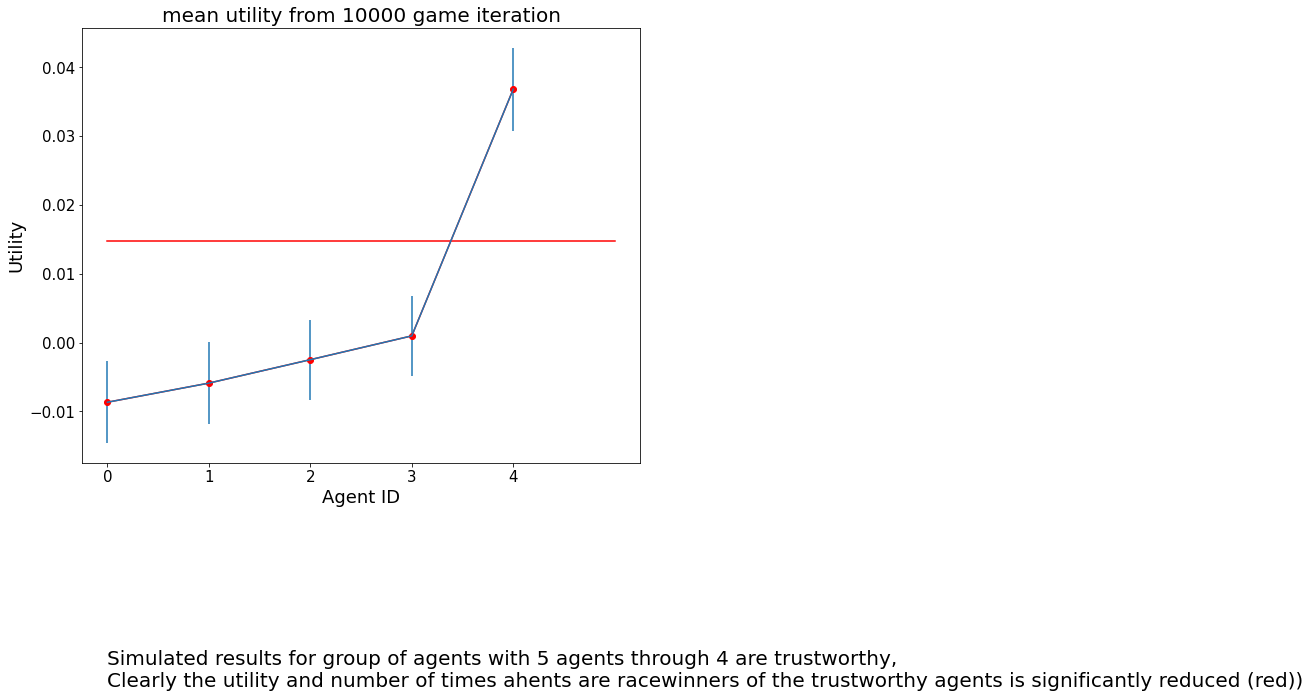

In [ ]:

# ---------------------  VISUALISE ----------------------- 

#  Compute statistics on utilities and compare utility for each agent with optimum utility.

print('---------end total utility ---------')

U_simul_mean = np.mean(Util, axis = 0) 

print('mean of utilities for each agents: ', U_simul_mean)

U_simul_std = np.std(Util, axis = 0)

U_simul_se = U_simul_std/np.sqrt(nr_game_iterations)

# plot mean utility for ... situation

nr_H = np.arange(H) # nr agents in the game

fig = plt.figure(figsize=(10,8))

plt.plot(U_simul_mean,'ro-');

plt.errorbar(nr_H,U_simul_mean,U_simul_se);

plt.xticks(np.arange(0,H,1));

print('optimum utility u* = ', u_star)
print('-----------------------------------')
plt.plot([0,H], [u_star, u_star], 'r');

# figure propertise
plt.title('''mean utility from {} game iteration'''.format(nr_game_iterations),fontsize=20);

plt.ylabel('Utility',fontsize=18)
plt.xlabel('Agent ID', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#---------------------


caption = '''
Simulated results for group of agents with {} agents through {} are trustworthy,
Clearly the utility and number of times ahents are racewinners of the trustworthy agents is significantly reduced (red))'''.format(H,Ht,Hd);

plt.text(0,-.05,caption, fontsize = 20);


# 7. Trigger Strategy based on Detection of Non-compliance:


After playing the game for a number of times, 

* If all agents commit to the probabilistic sniping  strategy,  each HFT expects to earn (on average)$u*_K$ per round.  

* If, however, there are rogue agents that engagein  sniping  at  every  occasion,  then  the  utility  for  the  trustworthy  agents  will  go  down

 1.  as market makers they will suffer from more intense sniping
 2. as bandits they will have to race against an (on average) larger group of competing bandits.
 
Notice  that  both  of  the  above  effects  are  related  to  the  fact  that  a  compliant  or trustworthy  agent  will  be  less  successful  in  winning  the  sniping  race. 

#7.1. Detection strategy based on racewinner frequencies:
By monitoring correlated number of times trustworthy agents succeeds in winning the sniping race, an agent can reliably decide whether or not the other agents are complying.

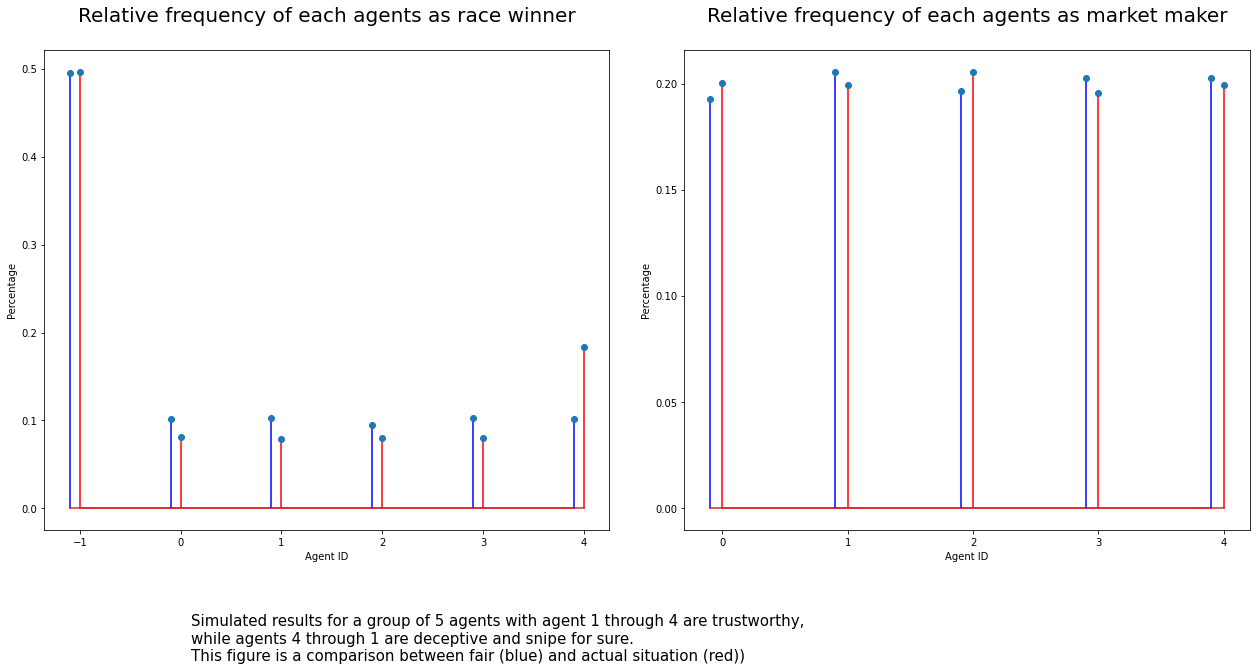

In [ ]:

# Visual check on race winner (RW) 

# race winner frequency if there are deceptive agents
RW_tb1_actual = collections.Counter(RW);
RW_tb1_actual = sorted(RW_tb1_actual.items());
RW_tb1_actual = np.asarray(RW_tb1_actual);
RW_tb1_actual = RW_tb1_actual[:,1]/nr_game_iterations

# race winner frequency if all agents are trustworthy
RW_tb1_fair = collections.Counter(RW_fair);
RW_tb1_fair = sorted(RW_tb1_fair.items());
RW_tb1_fair = np.asarray(RW_tb1_fair);
RW_tb1_fair = RW_tb1_fair[:,1]/nr_game_iterations

x= np.arange(-1,H); # define nr_agents (no race = -1)


#----------
# check the frequency of being selected as market maker (MM)

# MM frequency if there are deceptive agents
MM_tb1_actual = collections.Counter(MM);
MM_tb1_actual = sorted(MM_tb1_actual.items());
MM_tb1_actual = np.asarray(MM_tb1_actual);
MM_tb1_actual = MM_tb1_actual[:,1]/nr_game_iterations

# MM frequency if all agents are trustworthy
MM_tb1_fair = collections.Counter(MM_fair);
MM_tb1_fair = sorted(MM_tb1_fair.items());
MM_tb1_fair = np.asarray(MM_tb1_fair);
MM_tb1_fair = MM_tb1_fair[:,1]/nr_game_iterations


fig, ax = plt.subplots(1,2, figsize = (18,8))

ax[0].stem(x, RW_tb1_actual, 'r')
ax[0].stem(x-.1,RW_tb1_fair, 'b' )

ax[0].set_title('Relative frequency of each agents as race winner\n',fontsize=20)


ax[1].stem(x[1::], MM_tb1_actual, 'r')
ax[1].stem(x[1::]-.1, MM_tb1_fair, 'b')

ax[1].set_title('Relative frequency of each agents as market maker\n',fontsize=20)


caption = '''
Simulated results for a group of {} agents with agent {} through {} are trustworthy, 
while agents {} through {} are deceptive and snipe for sure.
This figure is a comparison between fair (blue) and actual situation (red))'''.format(H,1, Ht, 4, Hd)

for ax in ax.flat:
    ax.set(xlabel='Agent ID', ylabel='Percentage')
fig.tight_layout()
plt.figtext(.15,-.15, caption, fontsize = 15,wrap=True);



# 7.2. Detection strategy based on average utility 

**(KPD.section.5.2)**

The presence of deceptive agent will push down trustworthy agent's utility, and observing this unexpected downturn  will  prompt  them  to  renege  on  their  earlier  commitment  to  the  probabilistic  snipingstrategy.   

By  monitoring average or aggregated utility, an agent can reliably decide whether or not the other agents are complying.

---------end total utility ---------
mean of utilities for each agents (actual situation):  [-0.00866162 -0.00588493 -0.00247917  0.00097681  0.03681883]
mean of utilities for each agents (fair situation):  [0.00655124 0.01261137 0.01838419 0.00640345 0.01594935]
optimum utility u* =  0.014694766013230049
-----------------------------------


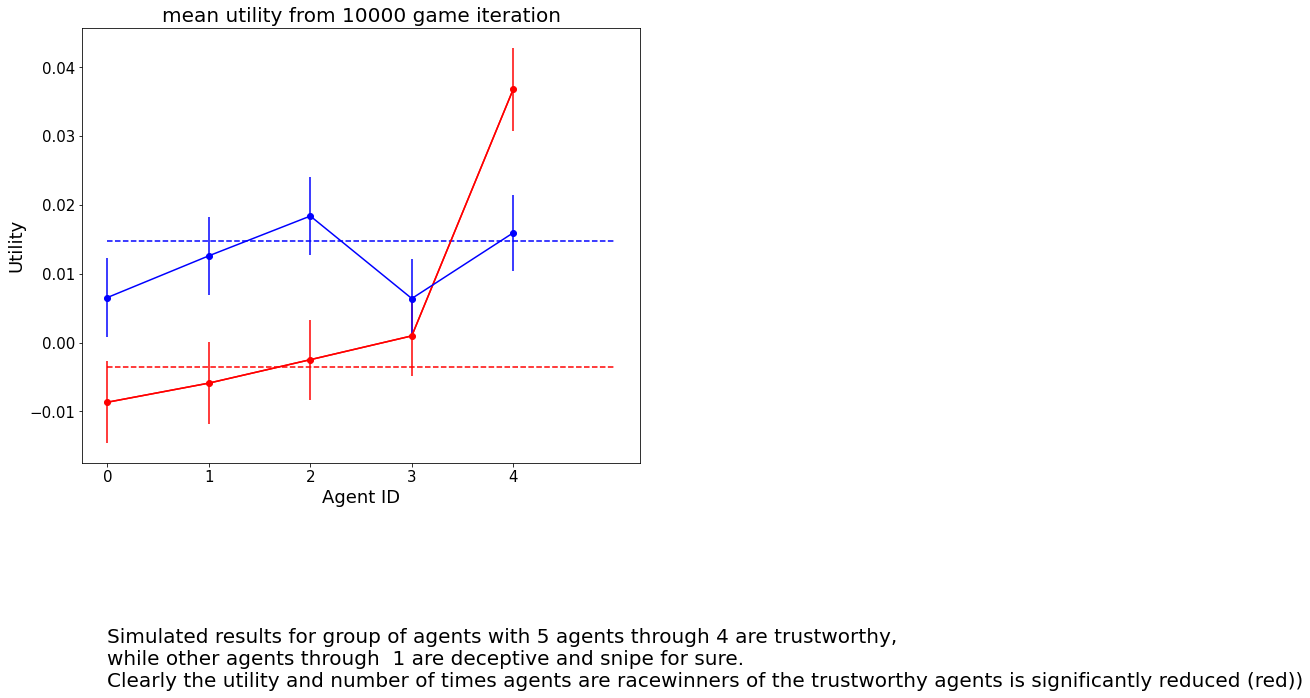

In [ ]:
#  Compute statistics on utilities and compare utility for each agent with optimum utility.

print('---------end total utility ---------')

#------ Actual situation (presence of deveptive agent)
U_simul_mean = np.mean(Util, axis = 0) 

print('mean of utilities for each agents (actual situation): ', U_simul_mean)

U_simul_std = np.std(Util, axis = 0)

U_simul_se = U_simul_std/np.sqrt(nr_game_iterations)

#----- fair situation
U_simul_mean_fair = np.mean(Util_fair, axis = 0) 

print('mean of utilities for each agents (fair situation): ', U_simul_mean_fair)

U_simul_std_fair = np.std(Util_fair, axis = 0)

U_simul_se_fair = U_simul_std_fair/np.sqrt(nr_game_iterations)

#------
u_as_t = equi_info['util_as_t']

#------ plot mean utility for ... situation

nr_H = np.arange(H) # nr agents in the game

fig = plt.figure(figsize=(10,8))

plt.plot(U_simul_mean,'ro-');
plt.plot(U_simul_mean_fair, 'bo')

plt.errorbar(nr_H,U_simul_mean,U_simul_se, color = 'red');
plt.errorbar(nr_H, U_simul_mean_fair, U_simul_se_fair, color = 'blue')
plt.xticks(np.arange(0,H,1));

print('optimum utility u* = ', u_star)

print('-----------------------------------')
plt.plot([0,H], [u_as_t, u_as_t], 'r--');
plt.plot([0,H], [ util_p_star, util_p_star], 'b--' )
# figure propertise
plt.title('''mean utility from {} game iteration'''.format(nr_game_iterations),fontsize=20);

plt.ylabel('Utility',fontsize=18)
plt.xlabel('Agent ID', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#---------------------

caption = '''
Simulated results for group of agents with {} agents through {} are trustworthy,
while other agents through  {} are deceptive and snipe for sure. 
Clearly the utility and number of times agents are racewinners of the trustworthy agents is significantly reduced (red))'''.format(H,Ht,Hd);
plt.text(0,-.05,caption, fontsize = 20);


# 7.3. Non-compliance detection based on sequential  utility testing



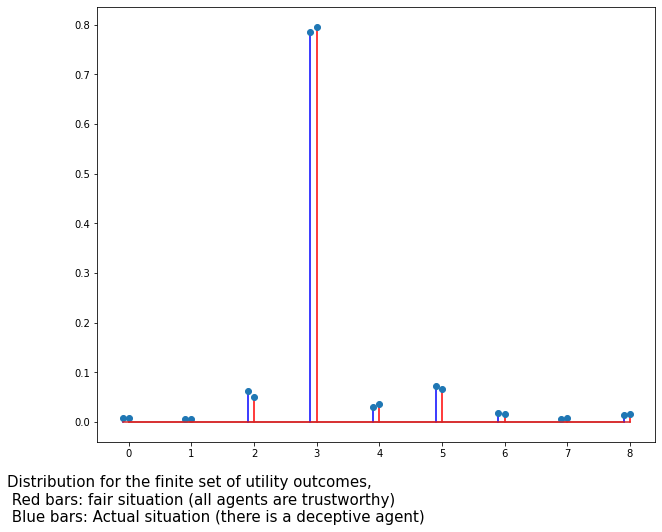

In [ ]:

# check the distribution for the finite set of utility outcomes in both situations (fair and actual)

#------ check the frequency of each utility in the fair situation (when all agents are trustworthy)

# Util_fair is a matrix of size (nr_game_iterations, H), each row stores the utility 
# of all agents in the corresponding game iteration.  

# 1: Count the number of times each utility has been repeated for each column in Util_fair 
fair_util_prob = []

'''
for row in Util_fair.T:   #  cycle over the cols of original matrix Util_fair (rows in transpose)
  # Count the frequency in each col of original = row of transpose 
  Util_fair_tb1_actual = collections.Counter(row);
  #print(Util_actual_tb1_actual)
  Util_fair_tb1_actual = sorted(Util_fair_tb1_actual.items());
  print(Util_fair_tb1_actual)
  fair_util_prob.append(Util_fair_tb1_actual)

print(fair_util_prob)
'''
# cycle over the agents
for agent in range(H):   
  # Use counter function to tabulate the occurrence of each unique utility in the column (agent)
  # (i.e. outcomes for a specific agent ag)
  Util_fair_tb1_actual = collections.Counter(Util_fair[:,agent]);
  # sort on value of utility
  Util_fair_tb1_actual = sorted(Util_fair_tb1_actual.items());
  # store in list
  fair_util_prob.append(Util_fair_tb1_actual)


# 2: collect the utilities and frequencies in a two-column dataframe
#  this is the input for the stem diagram
st_fair_util = pd.DataFrame(fair_util_prob).transpose() 
st_fair_util_prob = pd.DataFrame(st_fair_util[0].tolist())  # util freq for agent 1

# 3: the percentage of utility freqs; 
# st_fair_util_prob[1] is the nr of times util for the first agent repeated
st_fair_util_prob = st_fair_util_prob[1].divide(nr_game_iterations)
#=========================
# The same for actual situation (when there is deceptive agent)

actual_util_prob = []
# cycle over the agents
for agent in range(H):   
  # Use counter function to tabulate the occurrence of each unique utility in the column (agent)
  # (i.e. outcomes for a specific agent ag)
  Util_actual_tb1_actual = collections.Counter(Util[:,agent]);
  # sort on value of utility
  Util_actual_tb1_actual = sorted(Util_actual_tb1_actual.items());
  # store in list
  actual_util_prob.append(Util_actual_tb1_actual)


# 2: collect the utilities and frequencies in a two-column dataframe
#  this is the input for the stem diagram
st_actual_util = pd.DataFrame(actual_util_prob).transpose() 
st_actual_util_prob = pd.DataFrame(st_actual_util[0].tolist())  # util freq for agent 1

# 3: the percentage of utility freqs
st_actual_util_prob = st_actual_util_prob[1].divide(nr_game_iterations)


#=====================
#plot the probability 9 possible utilities in the game (According to the table)

x = np.arange(0,len(st_fair_util_prob))
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.stem(x, st_fair_util_prob, 'r');
ax.stem(x-.1, st_actual_util_prob,'b');
plt.figtext(0,-.01, '''Distribution for the finite set of utility outcomes,\n Red bars: fair situation (all agents are trustworthy) \n Blue bars: Actual situation (there is a deceptive agent)''', fontsize = 15,wrap=True);



# 8. Quantify the non-compliance effect on the race winner frequency:

How to quantify the effect of deceptive agents on frequency of winning the race.

By comparing the expected number of times for winning the race and both actual and fair situation, agents can keep track of the number of times they win the race.

 $$ \pi_{RW}(p) := 
 P\left\{\mbox{Individual agent wins race} | \mbox{ there 
 was a race and  agents enter race w.p. } p\right\}$$


* if the agent is market maker, the probability of winning the race is $1-h(p)$ (ref, KPD.section.3.2)
     
* If the agent is a bandit, then the probability that he will win the race equals $p\, g(p) =h(p)/(H-1)$


Multiplying this by the probability that there is a race ($\beta$) allows each agent to predict how many times 
he expects to be racewinner: 
%
$$ \mbox{Expected number of racewins} = 
\frac{\beta}{H} \,  \mbox{(number of stage games)}
$$



#8.1. Cumulative number of times a specific agent is racewinner

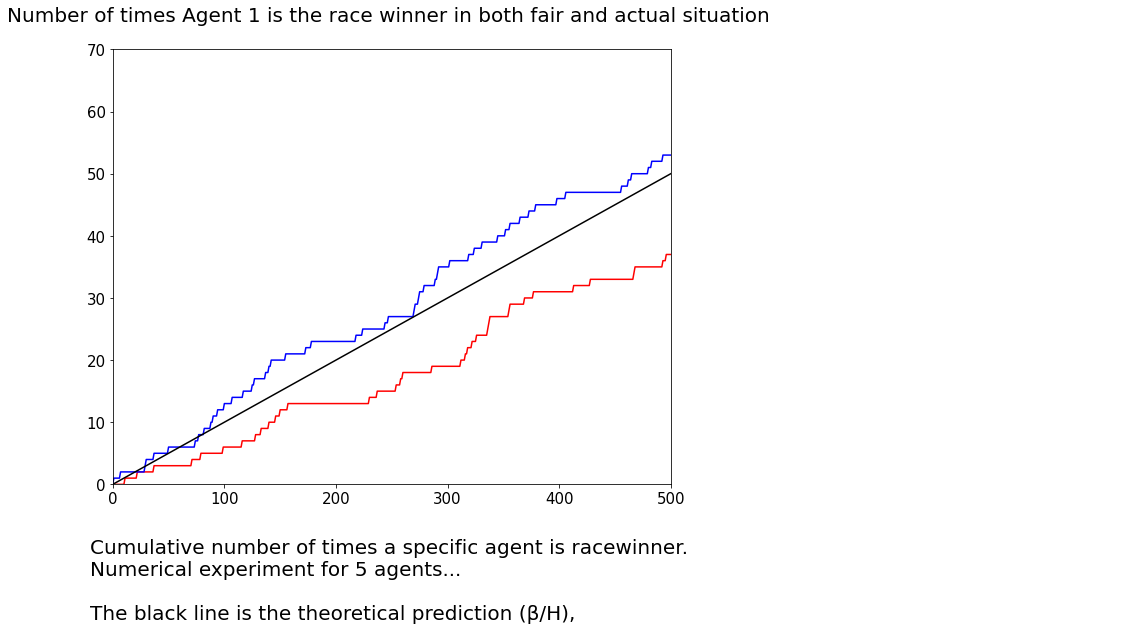

In [ ]:

RW_1_actual = np.zeros(nr_game_iterations) 
RW_1_fair = np.zeros(nr_game_iterations) 


for i in range(nr_game_iterations): 
  if RW[i] == 1: 
    RW_1_actual[i] = 1
  
  if RW_fair[i] ==1:
    RW_1_fair[i] =1
  

RW_cumsum_actual = np.cumsum(RW_1_actual)
RW_cumsum_fair = np.cumsum(RW_1_fair)

#------------------------
# Multiplying the probability that there is a race (β) 
# allows each agent to predict how manytimes he expects to be racewinner
beta = mz_params['beta']
RW_slope_expected = (beta/H)


fig_3 = plt.figure(figsize = (10,8))

x_actual = np.arange(len(RW_cumsum_actual))
plt.plot(x_actual, RW_cumsum_actual , 'r');

x_fair = np.arange(len(RW_cumsum_fair))
plt.plot( x_fair,RW_cumsum_fair, 'b');

plt.plot([0,500], [0,RW_slope_expected*500], 'k')
plt.xlim(0,500)
plt.ylim(0, 70)

# figure propertise
plt.title('Number of times Agent 1 is the race winner in both fair and actual situation \n ',fontsize=20);

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#---------------------

# Caption needs to be completed (ref to the  final text)

caption = '''
Cumulative number of times a specific agent is racewinner. 
Numerical experiment for {} agents...

The black line is the theoretical prediction (β/H),
Blue:simulated  cumulative  number  of  racewins  for  agent  1  assuming  everyone  behaves  fairly. 
Actual(red) number of racewins for agent 1 when there areHddeceptive agents.
(Reference KPD_textdoc_fig 18 p.)'''.format(H);
plt.text(0,-.3,caption, fontsize = 20,transform=ax.transAxes);

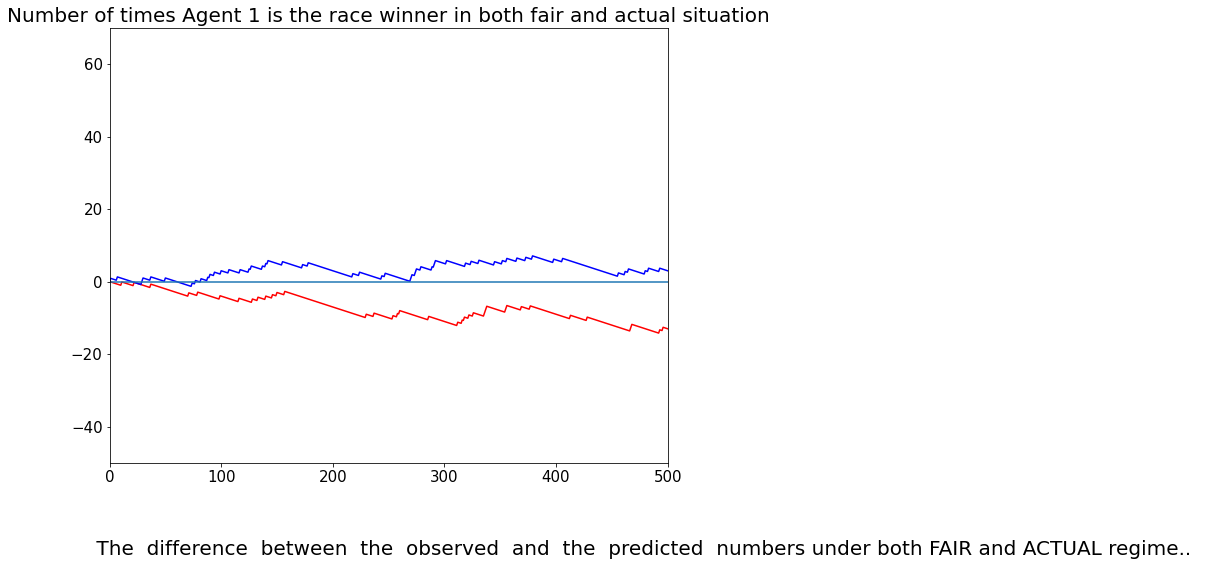

In [ ]:
RW_cumsum_fair_theo = RW_cumsum_fair - RW_slope_expected*(np.arange(0,nr_game_iterations))
RW_cumsum_actual_theo = RW_cumsum_actual - RW_slope_expected*(np.arange(0,nr_game_iterations))


fig = plt.figure(figsize = (10,8))

x_actual_theo = np.arange(len(RW_cumsum_actual_theo))
plt.plot(x_actual_theo ,RW_cumsum_actual_theo, 'r');

x_fair_theo = np.arange(len(RW_cumsum_fair_theo))
plt.plot( x_fair_theo,RW_cumsum_fair_theo, 'b');

plt.axhline(0,0)
plt.xlim(0,500)
plt.ylim(-50, 70)

# figure propertise
plt.title('Number of times Agent 1 is the race winner in both fair and actual situation',fontsize=20);

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#---------------------

# Caption needs to be completed (ref to the  final text)

caption = '''
 The  difference  between  the  observed  and  the  predicted  numbers under both FAIR and ACTUAL regime..
(Reference KPD_textdoc_fig 18 p.)''';
plt.text(0,-.2,caption, fontsize = 20,transform=ax.transAxes);

# 8.2. Cumulative Rewards for trustworthy and deceptive agents

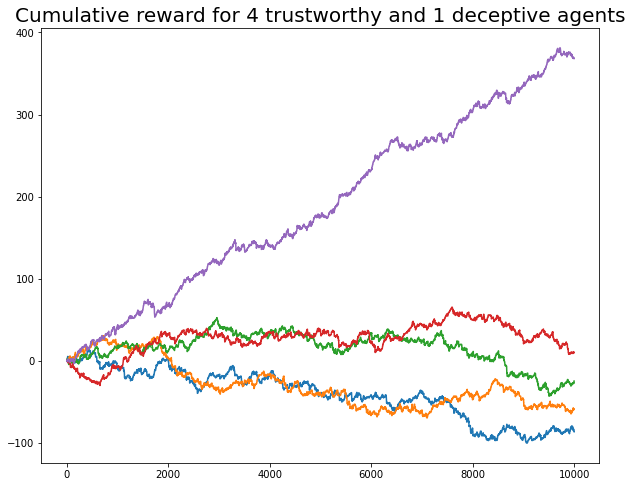

In [ ]:
# Compute cumulative sum of utility for each agents
cum_1 = np.cumsum(Util[:,0])
cum_2 = np.cumsum(Util[:,1])
cum_3 = np.cumsum(Util[:,2])
cum_4 = np.cumsum(Util[:,3])
cum_5 = np.cumsum(Util[:,4])
#----
plt.plot(cum_1)
plt.plot(cum_2)
plt.plot(cum_3)
plt.plot(cum_4)
plt.plot(cum_5)
plt.title(('''Cumulative reward for {} trustworthy and {} deceptive agents''').format(Ht, Hd),fontsize=20);

# 9. Compare probability of each utility for MM and bandit

**(KPD.section.5.3.2)**


 - MM == RW means MM enters and wins the race.
 - MM != RW means bandit wins the race with probability $\frac{(H-1)}{H} \cdot p\cdot g_{tb}(p)$  and MM loses the race with probability $h_{tm}(p)$


In [ ]:
#-----------
# First: Find util when mm wins the race (RW==MM)
# and when mm is not the race winner (RW != MM ), bandit is the race winner.

# To store race winner utility
util_MM_win=[]
util_MM_lose =[] 

for rw, mm, util_mm in zip(RW,MM,Util):
    if rw == mm:
        util_MM_win.append(util_mm)
    else:
      util_MM_lose.append(util_mm)

#------------
# Second: Compute the nr of times each utility repeated

# convert lists to array
util_mm_rwy = np.array(util_MM_win)
util_mm_rwn = np.array(util_MM_lose)

util_mm_rwy_prob = []
util_mm_rwn_prob = []
for agent_mm in range (len(util_mm_rwy[0])):   
  # Use counter function to tabulate the occurrence of each unique utility in the column (agent)
  # (i.e. outcomes for a specific agent ag)
  util_mm_win_tbl = collections.Counter(util_mm_rwy[:,agent_mm]);
  util_mm_lose_tbl = collections.Counter(util_mm_rwn[:,agent_mm]);
  # sort on value of utility
  util_mm_win_tbl = sorted(util_mm_win_tbl.items());
  util_mm_lose_tbl = sorted(util_mm_lose_tbl.items());
  # store in list
  util_mm_rwy_prob.append(util_mm_win_tbl)
  util_mm_rwn_prob.append(util_mm_lose_tbl)

# The result of collection counter is tuble columns, so we need to extract 
# tubles by turning each column into a list and store them in the dataframe (easier to see the result)

util_prob_tb = pd.DataFrame(util_mm_rwy_prob).transpose() 
util_prob_tb_1 = pd.DataFrame(util_prob_tb[0].tolist())  # for agent 1
util_prob_tb_2 = pd.DataFrame(util_prob_tb[1].tolist())  # for agent 2
util_prob_tb_3 = pd.DataFrame(util_prob_tb[2].tolist())  # for agent 3
util_prob_tb_4 = pd.DataFrame(util_prob_tb[3].tolist())  # for agent 4
util_prob_tb_5 = pd.DataFrame(util_prob_tb[4].tolist())  # for agent 5


# List all possible utility outcome :
# Now we can either combine probability of utilites for each agents (if we do, then we need to multipy theoratical result by nr.agents) 
# Or plot the probability for each agent 
# ----------------- both results are the same approximately
#------------------
# to combine the prob and util of all agents we need to use concat to append all agent utility 
df = pd.DataFrame()

# df = pd.concat([util_prob_tb_1,util_prob_tb_2,util_prob_tb_3,util_prob_tb_4,util_prob_tb_5]).reset_index(drop=True)
# But now we extract prob and utility for one agent
df = util_prob_tb_1.reset_index(drop=True)

df['Counter'] =df[1].divide(nr_game_iterations)
#----- merge duplicated rows In case there are util and prob repeated
df_mm_win = df.groupby ( df[0]) [ 'Counter' ].sum () 


# MM Loses or bandit wins the race
util_prob_tb_lose = pd.DataFrame(util_mm_rwn_prob).transpose() 
util_prob_tb_lose_1 = pd.DataFrame(util_prob_tb_lose[0].tolist())  
util_prob_tb_lose_2 = pd.DataFrame(util_prob_tb_lose[1].tolist())  
util_prob_tb_lose_3 = pd.DataFrame(util_prob_tb_lose[2].tolist()) 
util_prob_tb_lose_4 = pd.DataFrame(util_prob_tb_lose[3].tolist())  
util_prob_tb_lose_5 = pd.DataFrame(util_prob_tb_lose[4].tolist())  
# -------------
# lists of all possible utility outcome  
# -------------
df1 = pd.DataFrame()
# Combine lists  
df1 = pd.concat([util_prob_tb_lose_1,util_prob_tb_lose_2,util_prob_tb_lose_3,util_prob_tb_lose_4,util_prob_tb_lose_5]).reset_index(drop=True)
# compute frequency of each utility by dividing nr of times utility happens and the nr of game iteration 
df1['Counter'] = util_prob_tb_lose_1[1].divide(nr_game_iterations)

#----- merge duplicated rows
df_mm_lose = df1.groupby ( df1[0]) [ 'Counter' ].sum () 

#-----------------
# Combine dataframes for MM and bandit 
df_mm_freq_simdata = pd.concat([df_mm_lose,df_mm_win])
# Merge duplicate values
df_mm_freq_simdata= df_mm_freq_simdata.groupby ( df_mm_freq_simdata.index ).sum ()

#df_mm_freq_simdata = df_mm_freq_simdata.drop(df_mm_freq_simdata.index[[3]]) # remove zero rows
print('============ probability of  each utility from Simulation =========')
print(df_mm_freq_simdata)

============ probability of  each utility from Simulation =========
0
-4.20432    0.0080
-1.79568    0.0050
-1.20432    0.0613
 0.00000    0.7851
 0.40144    0.0305
 0.59856    0.0723
 1.19712    0.0176
 1.40144    0.0056
 1.59856    0.0146
Name: Counter, dtype: float64


# 9.1 To compare the result with Utility table (Theoratical data)
**We recall some initial parameteres including probability of bandit wins and MM loses the race g_tb, h_tm, respectively.**

In [ ]:
# Introduce the primary parameters
from sympy import *
from sympy.abc import gamma, s, sigma
alpha = 0.45
mu=.5
delta=.5
p = .39
s = 0.598559976663086
beta = alpha/(alpha + mu)
alphabar = alpha * delta /2
mubar = mu* delta/2

Ht = 4
Hd=1
H = Ht+Hd
sigma =1 
gamma =3
def compute_htm_gtb(Ht, Hd, p) :
        '''
        Compute ht_m (trustworthy agent as Market maker)
        and g_tb (trustworthy agent as bandit)

        '''
        H = Hd + Ht
        nr_simul = 10000
        Nt = np.random.binomial ( Ht - 1, p, size=(nr_simul, 1) )
        h_tm = np.mean ( (Hd + Nt) / (1 + Hd + Nt) )

        Nt_1 = np.random.binomial ( Ht - 2, p, size=(nr_simul, 1) )
        Nt_2 = np.random.binomial ( Ht - 1, p, size=(nr_simul, 1) )
        g_tb = np.mean ( 1 / (2 + Hd + Nt_1) ) * ((Ht - 1) / (H - 1)) + np.mean ( 1 / (1 + Hd + Nt_2) ) * (Hd / (H - 1))

        # Check gtb
        Nt = np.random.binomial ( Ht - 1, p, size=(nr_simul, 1) )
        g_tb_2 = (1 / (H - 1)) * np.mean (
            Hd * (1. / (1 + Nt + Hd)) + Nt / (1 + Nt + Hd) + (Ht - 1 - Nt) / (2 + Nt + Hd) )

        if Ht <= 0 :
            print ( 'Number of trustworthy agents Ht needs to be at least one!' )

        return g_tb, h_tm
# Assumption for fair situation where p = p* (say 0.39) for everyone (MM, bandit)
g_tb = compute_htm_gtb ( Ht, Hd, p ) [ 0 ]
h_tm = compute_htm_gtb ( Ht, Hd, p) [ 1 ]

# Assumption for fair situation where p = 1 for bandit
g_tb_actual = compute_htm_gtb ( Ht, Hd, 1 ) [ 0 ]

my_dict = {'alphabar': alphabar, 'mubar': mubar, 'beta': beta, 'p':.39, 'H': H, 'g_tb':g_tb, 'h_tm':h_tm}




# 9.2. Introduce a dictionary of probabilities for each utility computed in (KPD.section.5.3.2)

In [ ]:
# Bandit utility 

prob_util_table_bandit =[ {2*sigma -s: alphabar*beta*p*g_tb*((H-1)/H) ,sigma -s: beta*((H-1)/H)*p*g_tb*(1-2*alphabar -mubar),
                           -gamma*s: beta*alphabar*((H-1)/H)*p*g_tb,0: ((H-1)/H)*(1-beta + beta*mubar + beta*(1-p*g_tb)*(1-mubar)) }] 

# MM utility 

prob_util_table_mm = [{s: (1/H)*((alphabar*beta*h_tm) + (1-beta)*(1-2*alphabar - mubar)),
                       gamma*(s-sigma): (1/H)*(alphabar*(1-beta)+beta*h_tm*(1-2*(alphabar+mubar))+beta*mubar),
                       s+sigma : (1/H)* (beta*mubar*(1-h_tm)+alphabar*(1-beta)), 2*s: mubar*(1/H)*(beta*h_tm+ (1-beta)),gamma*(s - 2*sigma): alphabar*beta*(1/H)*h_tm,
                       0: (1/H)* (beta)*(1-h_tm)* (1-2*mubar) }]

#------ Store dictionaries in dataframes for clearer visulaisation 
bandit_util_freq_check = pd.DataFrame(prob_util_table_bandit).transpose()
MM_util_freq_check = pd.DataFrame(prob_util_table_mm).transpose()

#----------
# combine all utilites and probs columns and sort them from A-Z
df_mm_freq_theodata = pd.concat([MM_util_freq_check,bandit_util_freq_check]).sort_index(ascending=True)
df_mm_freq_theodata= df_mm_freq_theodata.groupby ( df_mm_freq_theodata.index ).sum ()
print('============ probability of  each utility from utility table =========')
print( df_mm_freq_theodata)

============ probability of  each utility from utility table =========
                 0
-4.20432  0.007031
-1.79568  0.004817
-1.20432  0.056496
 0.00000  0.786711
 0.40144  0.027833
 0.59856  0.075452
 1.19712  0.020970
 1.40144  0.004817
 1.59856  0.015872


============ probability of  each utility from Simulation =========
0
-4.20432    0.0080
-1.79568    0.0050
-1.20432    0.0613
 0.00000    0.7851
 0.40144    0.0305
 0.59856    0.0723
 1.19712    0.0176
 1.40144    0.0056
 1.59856    0.0146
Name: Counter, dtype: float64
============ probability of  each utility from utility table =========
                 0
-4.20432  0.007031
-1.79568  0.004817
-1.20432  0.056496
 0.00000  0.786711
 0.40144  0.027833
 0.59856  0.075452
 1.19712  0.020970
 1.40144  0.004817
 1.59856  0.015872


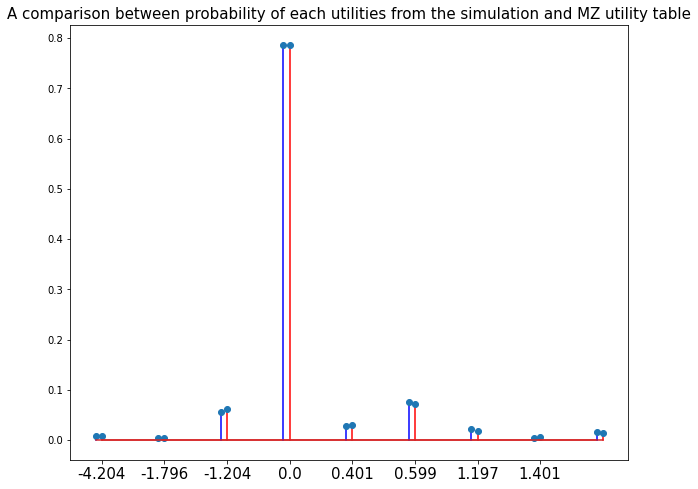

In [ ]:
x= np.arange(9)
plt.stem(x, df_mm_freq_simdata,'-r')
plt.stem(x-.1, (df_mm_freq_theodata.values),'-b')
plt.xticks ( np.arange ( 0, 8, step=1 ), np.round(df_mm_freq_simdata.index,3), rotation='horizontal', fontsize=15 );
plt.title ('A comparison between probability of each utilities from the simulation and MZ utility table',fontsize=15 );

print('============ probability of  each utility from Simulation =========')
print(df_mm_freq_simdata)
print('============ probability of  each utility from utility table =========')
print( df_mm_freq_theodata)

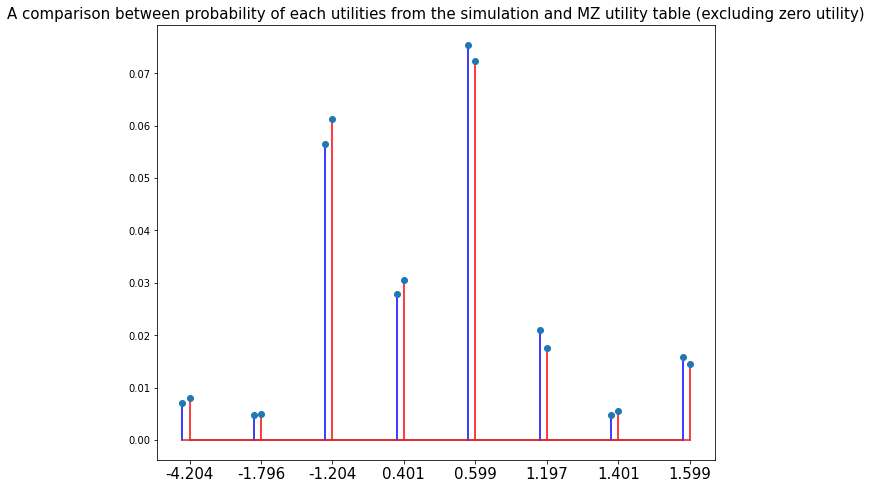

In [ ]:
#-----
# Removing zero utility for claritying of other utilities
df_mm_freq_simdata_non_zero = df_mm_freq_simdata.drop(df_mm_freq_simdata.index[[3]]) # remove zero row
df_mm_freq_theodata_non_zero= df_mm_freq_theodata.drop(df_mm_freq_simdata.index[[3]]) # remove zero row
# plot
x= np.arange(8)
plt.stem(x, df_mm_freq_simdata_non_zero,'-r')
plt.stem(x-.1, (df_mm_freq_theodata_non_zero.values),'-b')
plt.xticks ( np.arange ( 0, 8, step=1 ), np.round(df_mm_freq_simdata_non_zero.index,3), rotation='horizontal', fontsize=15 );
plt.title ('A comparison between probability of each utilities from the simulation and MZ utility table (excluding zero utility)', fontsize = 15);


# 10 . Wald sequential probability ratio test

**(KPD.section.5.3.2)**

To detect the non-compliance, we can use Wald's sequential 
probability ratio test: after observing (sequential) outcomes 
$x_1, x_2, \ldots, x_t$, one computes the current 
value for the sequential probability ratio: 
$$  S(t) = \sum_{i = 1}^t 
\log\frac{P(x_i | H_1)}{P(x_i | H_0)} $$

Introducing the notation :
$$ a =  -\log \frac{1-\alpha}{\beta}  
\quad\quad b = \log \frac{1-\beta}{\alpha}  $$

where $\alpha$ is type I error (significance) 
and $\beta$ is the type II error (power)  
- we get the following stopping rule: 
    - if $a < S_t <b $ : continue testing;
    - if $S_t < a$:  accept $H_0$
    - if $S_t >b $:  accept $H_1$ (i.e. reject $H_0$)
 

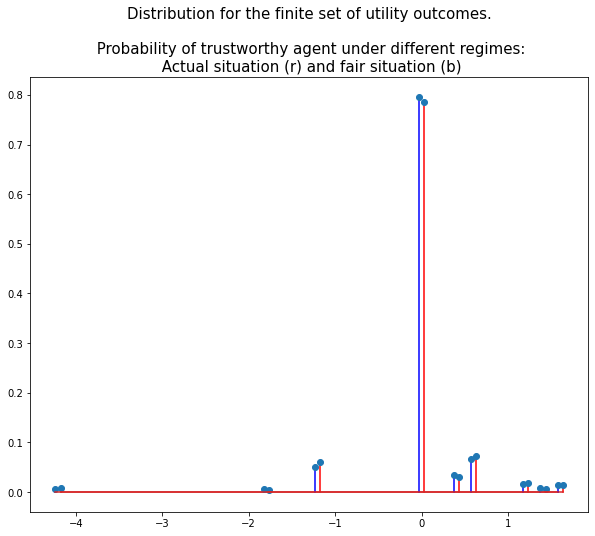

In [ ]:
# Actual situation
# Tabulate and compare 
util_prob_tb = pd.DataFrame(fair_util_prob).transpose() 
util_prob_tb_1 = pd.DataFrame(util_prob_tb[0].tolist())  # util freq for agent 1

# Both tables have the same common utilities 
utils_common = util_prob_tb_1[0]
Probs_utils_fair = st_fair_util_prob

Probs_utils_actual = st_actual_util_prob #st_actual_util_prob

plt.stem(utils_common +  .03  , Probs_utils_actual,'r');
plt.stem(utils_common - .03 , Probs_utils_fair,'b');
plt.title('Distribution for the finite set of utility outcomes.\n \n Probability of trustworthy agent under different regimes:\n Actual situation (r) and fair situation (b)', fontsize = 15);

In [ ]:
#---------
# SPRT 

alpha_type_1 = 0.05
beta_type_2 = 0.1
a = -np.log((1-alpha_type_1)/beta_type_2)
b = np.log((1-beta_type_2)/alpha_type_1)

pi_1 = Probs_utils_actual # distribution under alternative hypothesis (devious agent)
pi_0 = Probs_utils_fair   # distribution under null-hypothesis

#--------
# Now cycle over all the events and determine the log prob ratio of each outcome: 

nr_events = len(Util); 
S = np.zeros((1,nr_events));
u1_cumsum = np.zeros((1,nr_events));

for ii in range(0, 10000,1):
  
  u_now = Util[ii,1];    
  #print('ii = ', ii ,'  utility = ' , u_now);
    
  z = np.where(np.abs(utils_common - u_now) < 0.0001) 
  z = np.squeeze(z)
  #print(z);
  if ii>1:
    S[0][ii] = S[0][ii-1] + np.log(pi_1[z]/pi_0[z])
    u1_cumsum[0][ii] = u1_cumsum[0][ii-1] + u_now
  else :
    S[0][ii] = np.log(pi_1[z]/pi_0[z]);
    u1_cumsum[0][ii] =  u_now; 




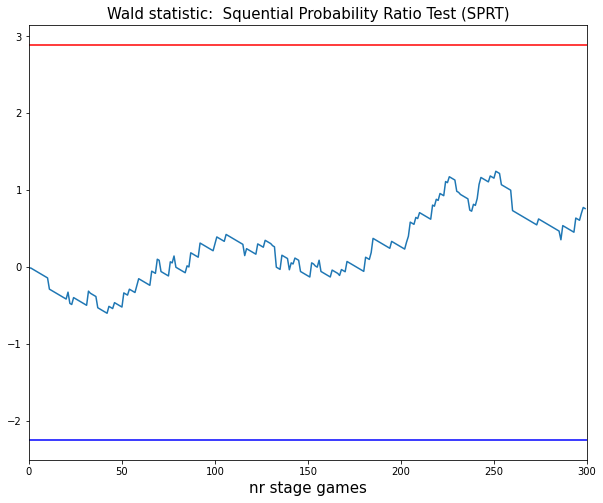

In [ ]:

S_1 = np.transpose(S)

stop_point = 300
plt.plot(S_1[0:stop_point])
plt.axhline(a, color="blue")
plt.axhline(b, color="red")
plt.title('Wald statistic:  Squential Probability Ratio Test (SPRT)', fontsize= 15)
plt.xlabel('nr stage games', fontsize = 15)
plt.xlim(0,stop_point)
plt.show()


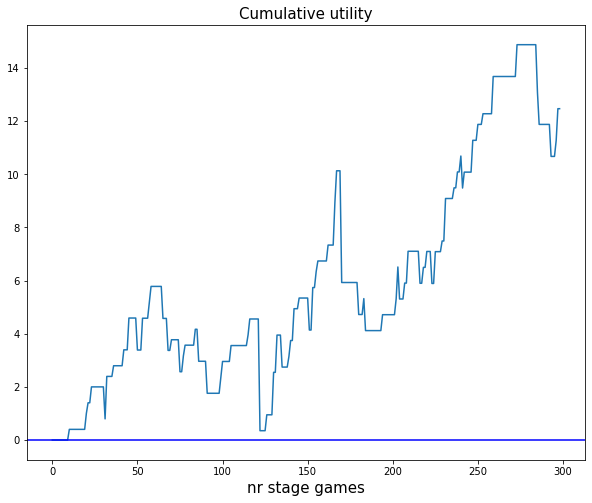

In [ ]:
u1_cumsum_1 = np.transpose(u1_cumsum)

plt.plot(u1_cumsum_1[1:stop_point])
plt.axhline(0, color="blue")
plt.title('Cumulative utility', fontsize = 15)
plt.xlabel('nr stage games', fontsize = 15)
plt.show()

